In [1]:
import pandas as pd
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef


In [2]:
url = 'https://raw.githubusercontent.com/PittariJonatan/Data-Sets/main/Airline%20Dataset%20Updated.csv'
df = pd.read_csv(url, sep = ',')

# Objetivo
## Desarrollar un modelo predictivo para reducir el riesgo de cancelaciones, entonces "Flight Status" será la variable "target", y específicamente, vamos a querer predecir cuando un vuelo  tiene tendencia a ser del tipo de estado "Cancelled".

### Contexto comercial

Los datos de las aerolíneas tienen una inmensa importancia ya que ofrecen información sobre el funcionamiento y la eficiencia de la industria de la aviación. Proporciona información valiosa sobre rutas de vuelo, horarios, datos demográficos de los pasajeros y preferencias, que las aerolíneas pueden aprovechar para optimizar sus operaciones y mejorar las experiencias de los clientes. Al analizar datos sobre retrasos, cancelaciones y puntualidad, las aerolíneas pueden identificar tendencias e implementar estrategias para mejorar la puntualidad y mitigar las interrupciones. Además, los organismos reguladores y los encargados de formular políticas dependen de estos datos para garantizar los estándares de seguridad, hacer cumplir las regulaciones y tomar decisiones informadas sobre las políticas de aviación.

### Problema comercial

Las cancelaciones de vuelos son un problema clave en la industria de la aviación. Los datos de las aerolíneas son esenciales para abordar este desafío y mejorar la eficiencia operativa, además de ser cruciales para reguladores, formuladores de políticas y analistas que buscan la seguridad y la toma de decisiones informadas.

### Contexto analítico

El data set posee información sobre 98619 filas, las cuales corresponden a un vuelo y pasajero específico, y 15 columnas las cuales detallamos brevemente a continuación:

- Passenger ID: Identificador único para cada pasajero.
- First Name: Nombre del pasajero.
- Last Name: Apellido del pasajero.
- Gender: Género del pasajero (por ejemplo, Masculino, Femenino).
- Age: Edad del pasajero.
- Nationality: Nacionalidad del pasajero.
- Airport Name: Nombre del aeropuerto desde donde el pasajero abordó el vuelo.
- Airport Country Code: Código del país donde se encuentra el aeropuerto.
- Country Name: Nombre del país donde se encuentra el aeropuerto.
- Airport Continent: Continente donde está situado el aeropuerto.
- Continents: Continentes involucrados en la ruta del vuelo.
- Departure Date: Fecha en que el vuelo partió.
- Arrival Airport: Aeropuerto de destino del vuelo.
- Pilot Name: Nombre del piloto que opera el vuelo.
- Flight Status: Estado actual del vuelo (por ejemplo, a tiempo, retrasado, cancelado).

In [3]:
df.head()

,Passenger ID,First Name,Last Name,Gender,Age,Nationality,Airport Name,Airport Country Code,Country Name,Airport Continent,Continents,Departure Date,Arrival Airport,Pilot Name,Flight Status
0,ABVWIg,Edithe,Leggis,Female,62,Japan,Coldfoot Airport,US,United States,NAM,North America,6/28/2022,CXF,Edithe Leggis,On Time
1,jkXXAX,Elwood,Catt,Male,62,Nicaragua,Kugluktuk Airport,CA,Canada,NAM,North America,12/26/2022,YCO,Elwood Catt,On Time
2,CdUz2g,Darby,Felgate,Male,67,Russia,Grenoble-Isère Airport,FR,France,EU,Europe,1/18/2022,GNB,Darby Felgate,On Time
3,BRS38V,Dominica,Pyle,Female,71,China,Ottawa / Gatineau Airport,CA,Canada,NAM,North America,9/16/2022,YND,Dominica Pyle,Delayed
4,9kvTLo,Bay,Pencost,Male,21,China,Gillespie Field,US,United States,NAM,North America,2/25/2022,SEE,Bay Pencost,On Time


# Interrogantes

- ¿Cuál es la tasa general de cancelación de vuelos en el conjunto de datos?

- ¿Existen tendencias o patrones evidentes en las cancelaciones respecto a otras categorías de vuelo?

- ¿Existe una relación entre la nacionalidad de los pasajeros y la frecuencia de cancelaciones de vuelos?

- ¿El país donde se encuentra el aeropuerto de origen afecta la probabilidad de cancelación de vuelos?

- ¿Hay alguna influencia de la edad o género de los pasajeros en la cancelación de vuelos?

- ¿Existen diferencias significativas en la tendencia de cancelaciones entre los continentes involucrados en la ruta del vuelo?

- ¿Las cancelaciones tienden a ocurrir en ciertas fechas o períodos específicos?

- ¿Hay alguna relación entre el piloto a cargo y la probabilidad de cancelación de vuelos?

- ¿El tamaño o la categoría del aeropuerto tienen impacto en la frecuencia de cancelaciones?

## Análisis Exploratorio

### Distribución de Estados de Vuelo

Utilizamos gráficos para visualizar la distribución de los estados de vuelo, como 'On Time', 'Delayed' y 'Cancelled'. Esto nos ofrece una perspectiva inicial sobre la frecuencia de cancelaciones en relación con otros estados.

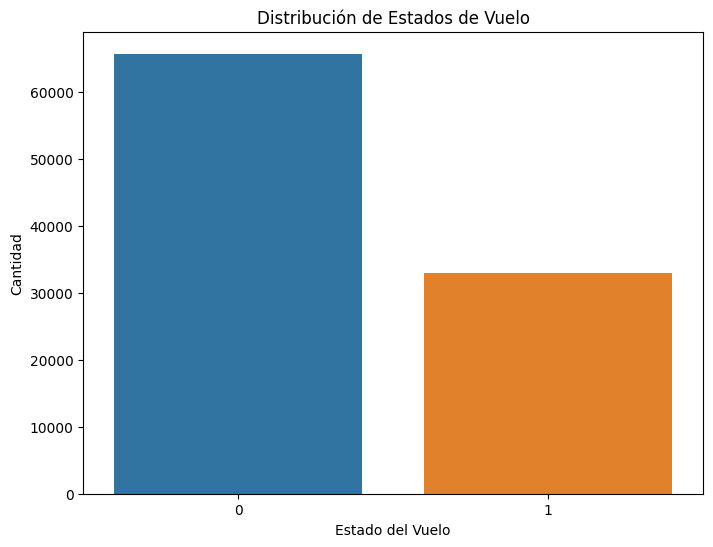

In [23]:

flight_status_count = df['Flight Status'].value_counts()

plt.figure(figsize=(8, 6))
sns.countplot(x='Flight Status', data=df, order=flight_status_count.index)
plt.title('Distribución de Estados de Vuelo')
plt.xlabel('Estado del Vuelo')
plt.ylabel('Cantidad')
plt.show()

## Limpieza y Preprocesamiento de Datos

Abordamos valores faltantes y duplicados para garantizar la integridad de nuestros análisis. Además, normalizamos los datos y nos aseguramos de que estén listos para ser utilizados en nuestro estudio.

#### Eliminamos las columnas First Name, Last Name y Pilot Name ya que no hay personas, ni pilotos con más de dos vuelos registrados. Son columnas que no agregaran un valor significativo a nuestro modelo predictivo. También dropeamos Airport Country Code y Airport Continent por una cuestión de redundancia con respecto a Country Name y Continents.

In [4]:
df = df.drop(columns= ['First Name', 'Last Name', 'Pilot Name', 'Airport Country Code', 'Airport Continent'])

#### Convertimos la variable Departure Date a formato tiempo.

In [5]:
df['Departure Date'] = pd.to_datetime(df['Departure Date'])

#### Cambiamos la numeración de Passenger ID de un formato con código asignado para el registro del aeropuerto a un rango de números mas legibles y de fácil procesamiento en caso de ser requerido.

In [6]:
df['Passenger ID'] = range(0, len(df))

####  Primero, debemos separar el data set en una parte para entrenamiento del algoritmo (df_train) y otra para el testeo del mismo (df_test). Como pretendemos realizar una regresión logística para predecir una posible cancelación en este conjuntos de datos, tomamos Flight Status la convertimos en una variable binaria. Dado que solo apuntamos a los cancelados ( == 1 ), tomaremos los On Time y Delayed como un mismo conjunto ( == 0 ). Posteriormente dividimos los datos en conjuntos de entrenamiento y prueba.

In [7]:
df['Flight Status'] = df['Flight Status'].apply(lambda x: 1 if x == 'Cancelled' else 0)

df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

In [8]:
df_train

,Passenger ID,Gender,Age,Nationality,Airport Name,Country Name,Continents,Departure Date,Arrival Airport,Flight Status
28204,28204,Male,61,Russia,Kabri Dehar Airport,Ethiopia,Africa,2022-09-07,ABK,0
6048,6048,Female,11,Portugal,Mornington Island Airport,Australia,Oceania,2022-02-15,ONG,1
67079,67079,Male,62,China,Dallas Fort Worth International Airport,United States,North America,2022-03-09,DFW,0
65825,65825,Female,49,Syria,Vinh Airport,Viet Nam,Asia,2022-07-10,VII,1
11010,11010,Female,72,Colombia,Jose Maria Velasco Ibarra Airport,Ecuador,South America,2022-01-20,MRR,1
...,...,...,...,...,...,...,...,...,...,...
6265,6265,Male,86,China,Moolawatana Airport,Australia,Oceania,2022-02-12,MWT,0
54886,54886,Male,43,Portugal,Minhas Air Base,Pakistan,Asia,2022-12-19,ATG,1
76820,76820,Female,15,Portugal,Boundary Airport,United States,North America,2022-06-26,BYA,0
860,860,Male,28,Indonesia,Sandstone Airport,Australia,Oceania,2022-01-03,NDS,0


#### Calculamos el valor de la correlación entre 'Age' y 'Flight Status'. El resultado es -0.003967036762306412, lo que indica que no hay una correlación lineal significativa entre la edad de los pasajeros y la probabilidad de que sus vuelos sean cancelados.

In [9]:
correlation_matrix = df_train[['Age', 'Flight Status']].corr()
correlation_age_target = correlation_matrix.loc['Age', 'Flight Status']
correlation_age_target

-0.003967036762306412

#### Convertimos la variable Gender a formato binario para su posterior evaluación del coeficiente de correlación de Matthews con respecto a Flight Status. El resultado es un valor muy cercano a cero. Esto indica que, al menos dentro del conjunto de datos de entrenamiento, no hay una asociación significativa entre el género del pasajero y la probabilidad de que su vuelo sea cancelado.

In [10]:
df_train['Gender Encoded'] = df_train['Gender'].apply(lambda x: 1 if x == 'Female' else 0)

phi_coefficient = matthews_corrcoef(df_train['Gender Encoded'], df_train['Flight Status'])
phi_coefficient

0.0010416881963464795

#### Primero calculamos la tasa de cancelación por aeropuerto en el conj. entrenamiento. Posteriormente mapeamos la tasa de cancelaciones y calculamos la correlación existente entre la variable Airport Cancellation Rate con respecto a nuestro Target, es decir, Flight Status.

In [11]:
airport_cancellation_rates = df_train.groupby('Airport Name')['Flight Status'].mean()

df_train['Airport Cancellation Rate'] = df_train['Airport Name'].map(airport_cancellation_rates)

correlation_airport_cancellation = df_train['Airport Cancellation Rate'].corr(df_train['Flight Status'])

correlation_airport_cancellation

0.36304321806028744

#### Vemos una relación positiva moderada. Esto sugiere que existe una asociación estadísticamente significativa entre el aeropuerto de donde parte el vuelo y la probabilidad de que el vuelo sea cancelado. Airport Cancellation Rate podría ser un predictor útil para incluir en el modelo de regresión logística.

#### Procedemos a indagar la correlación entre Country Name y nuestra variable Target [Flight Status], para ello en una primera instancia calculamos la tasa de cancelación por país en df_train. Posteriormente mapeamos dicha tasa en una variable llamada [Country Cancellation Rate] y como último paso, calculamos la relacion entre dicha columna y nuestro objetivo.

In [12]:
country_cancellation_rates = df_train.groupby('Country Name')['Flight Status'].mean()

df_train['Country Cancellation Rate'] = df_train['Country Name'].map(country_cancellation_rates)

correlation_country_cancellation = df_train['Country Cancellation Rate'].corr(df_train['Flight Status'])
correlation_country_cancellation

0.05431774887736149

#### El valor de correlación de 0.054, indica una correlación positiva, aunque bastante débil. Esto sugiere que hay una leve asociación entre el país desde el cual opera el vuelo y la probabilidad de que el vuelo sea cancelado. Aunque la tasa de cancelación de vuelos de un país tiene algún grado de relación con las cancelaciones de vuelos, no es un predictor fuerte por sí mismo.

#### Procedemos a indagar la correlación entre Continents y nuestra variable Target [Flight Status], para ello en una primera instancia calculamos la tasa de cancelación por país en df_train. Posteriormente mapeamos dicha tasa en una variable llamada [Continents Cancellation Rate] y como último paso, calculamos la relacion entre dicha columna y nuestro objetivo.

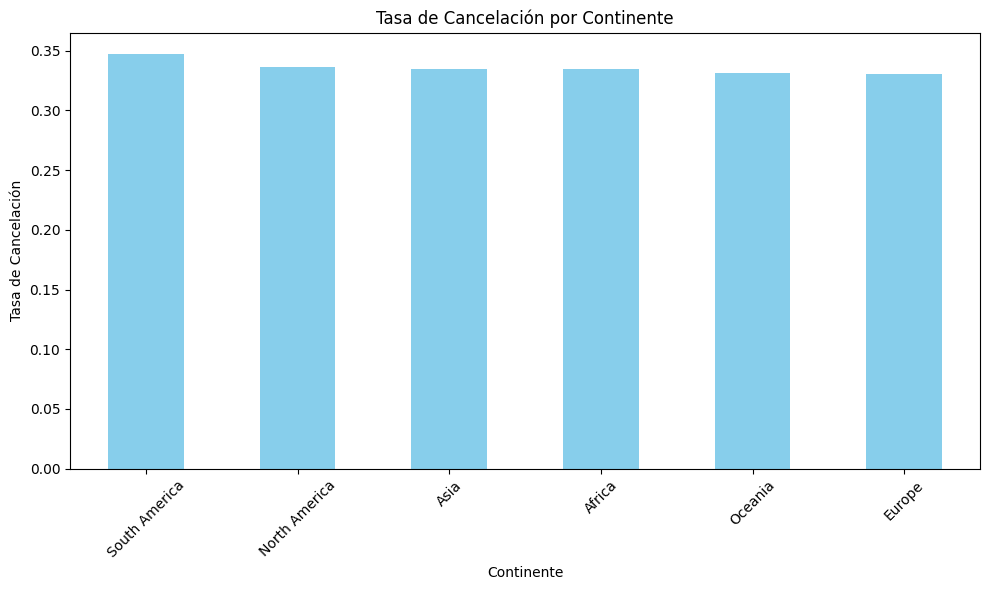

In [25]:
continents_cancellation_rates = continents_cancellation_rates.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
continents_cancellation_rates.plot(kind='bar', color='skyblue')
plt.title('Tasa de Cancelación por Continente')
plt.xlabel('Continente')
plt.ylabel('Tasa de Cancelación')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:
continents_cancellation_rates = df_train.groupby('Continents')['Flight Status'].mean()

df_train['Continents Cancellation Rate'] = df_train['Continents'].map(continents_cancellation_rates)

correlation_continents_cancellation = df_train['Continents Cancellation Rate'].corr(df_train['Flight Status'])
correlation_continents_cancellation

0.009946431396016754

#### Una correlación de 0.0099 es muy cercana a cero, indicando que no hay una relación lineal fuerte entre el continente de salida del vuelo y la probabilidad de cancelación del vuelo según los datos del conjunto de entrenamiento.

#### Evaluamos la correlación entre Nationality y nuestra variable Target [Flight Status], para ello en una primera instancia calculamos la tasa de cancelación por país en df_train. Posteriormente mapeamos dicha tasa en una variable llamada [Nationality Cancellation Rate] y como último paso, calculamos la relacion entre dicha columna y nuestro objetivo.

In [14]:
nationality_cancellation_rates = df_train.groupby('Nationality')['Flight Status'].mean()

df_train['Nationality Cancellation Rate'] = df_train['Nationality'].map(nationality_cancellation_rates)

correlation_nationality_cancellation = df_train['Nationality Cancellation Rate'].corr(df_train['Flight Status'])
correlation_nationality_cancellation

0.05854617537804673

#### Un coeficiente de correlación de 0.058 sugiere una correlación positiva muy débil. Esto implica que hay una leve relación entre la nacionalidad y la probabilidad de que un vuelo sea cancelado, pero no es una relación fuerte.

In [15]:
df_train

,Passenger ID,Gender,Age,Nationality,Airport Name,Country Name,Continents,Departure Date,Arrival Airport,Flight Status,Gender Encoded,Airport Cancellation Rate,Country Cancellation Rate,Continents Cancellation Rate,Nationality Cancellation Rate
28204,28204,Male,61,Russia,Kabri Dehar Airport,Ethiopia,Africa,2022-09-07,ABK,0,0,0.714286,0.324397,0.334713,0.333909
6048,6048,Female,11,Portugal,Mornington Island Airport,Australia,Oceania,2022-02-15,ONG,1,1,0.333333,0.336877,0.331148,0.346287
67079,67079,Male,62,China,Dallas Fort Worth International Airport,United States,North America,2022-03-09,DFW,0,0,0.285714,0.332097,0.335957,0.334953
65825,65825,Female,49,Syria,Vinh Airport,Viet Nam,Asia,2022-07-10,VII,1,1,0.538462,0.324324,0.334769,0.374502
11010,11010,Female,72,Colombia,Jose Maria Velasco Ibarra Airport,Ecuador,South America,2022-01-20,MRR,1,1,0.714286,0.391089,0.347554,0.352614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,6265,Male,86,China,Moolawatana Airport,Australia,Oceania,2022-02-12,MWT,0,0,0.200000,0.336877,0.331148,0.334953
54886,54886,Male,43,Portugal,Minhas Air Base,Pakistan,Asia,2022-12-19,ATG,1,0,0.454545,0.344398,0.334769,0.346287
76820,76820,Female,15,Portugal,Boundary Airport,United States,North America,2022-06-26,BYA,0,1,0.428571,0.332097,0.335957,0.346287
860,860,Male,28,Indonesia,Sandstone Airport,Australia,Oceania,2022-01-03,NDS,0,0,0.166667,0.336877,0.331148,0.336216


#### Procedemos a combinar dos variables Nationality e Airport Name en una nueva Airport_Nationality. Posteriormente agrupamos dicha variable según el promedio de Flight Status y procedemos a mapear dicha variable en una columna llamada Airport_Nationality Cancellation Rate. Por último calculamos el coeficiente de correlación de dicha variable con respecto a nuestro target.

In [16]:
df_train['Airport_Nationality'] = df_train['Airport Name'] + "_" + df_train['Nationality']

airport_nationality_cancellation_rates = df_train.groupby('Airport_Nationality')['Flight Status'].mean()

df_train['Airport_Nationality Cancellation Rate'] = df_train['Airport_Nationality'].map(airport_nationality_cancellation_rates)

correlation_airport_nationality_cancellation = df_train['Airport_Nationality Cancellation Rate'].corr(df_train['Flight Status'])
correlation_airport_nationality_cancellation

0.9103423663244122

#### Desglozamos la variable Departure Date en dos variables nuevas, la primera Month para ver por número de mes el movimiento, y la segunda Week (mismo procedimiento pero por número de semana).

In [17]:
df_train['Departure Date'] = pd.to_datetime(df_train['Departure Date'])

df_train['Month'] = df_train['Departure Date'].dt.month
df_train['Week'] = df_train['Departure Date'].dt.isocalendar().week

#### Observamos la correlación directa que existe por un lado entre la variable Month y Flight Status, y luego el mismo procedimiento pero con Week y nuestro target.

In [18]:
correlation_month_target = df_train['Month'].corr(df_train['Flight Status'])
print("Correlation between Month and Flight Status:", correlation_month_target)

correlation_week_target = df_train['Week'].corr(df_train['Flight Status'])
print("Correlation between Week and Flight Status:", correlation_week_target)

Correlation between Month and Flight Status: 0.004931293504924853
Correlation between Week and Flight Status: 0.006064469222700486


#### Las correlaciones que has encontrado entre 'Month' y 'Flight Status' (aproximadamente 0.0049) y entre 'Week' y 'Flight Status' (aproximadamente 0.0061) son muy bajas. Estos valores indican que no hay una relación lineal fuerte entre el mes o la semana del año de la fecha de salida y la probabilidad de que un vuelo sea cancelado.

In [19]:
# Crear una nueva columna que combine 'Airport Name' y 'Week'
df_train['Airport_Week'] = df_train['Airport Name'] + "_" + df_train['Week'].astype(str)

# Calcular la tasa de cancelación para cada combinación única de 'Airport Name' y 'Week'
airport_week_cancellation_rates = df_train.groupby('Airport_Week')['Flight Status'].mean()

# Mapear la tasa de cancelación de vuelta al conjunto de entrenamiento
df_train['Airport_Week Cancellation Rate'] = df_train['Airport_Week'].map(airport_week_cancellation_rates)

# Calcular la correlación entre esta nueva característica y 'Flight Status'
correlation_airport_week_cancellation = df_train['Airport_Week Cancellation Rate'].corr(df_train['Flight Status'])
correlation_airport_week_cancellation

0.9637032184658427

In [20]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression

# Asumiendo que df_train ya está preparado con las características y la variable objetivo
X = df_train[['Airport_Week Cancellation Rate']]  # las características
y = df_train['Flight Status']  # la variable objetivo

# Inicializar el modelo de regresión logística
model = LogisticRegression()

# Configurar la validación cruzada K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Calcular la precisión (accuracy) en cada pliegue usando cross_val_score
scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')

# Calcular la media y la desviación estándar de la precisión
mean_accuracy = scores.mean()
std_accuracy = scores.std()

print(f"Mean Accuracy: {mean_accuracy}")
print(f"Standard Deviation of Accuracy: {std_accuracy}")


Mean Accuracy: 0.9687685624428595
Standard Deviation of Accuracy: 0.0007419101627997263


In [21]:
# Entrenar el modelo en todo el conjunto de datos de entrenamiento después de realizar la validación cruzada
model = LogisticRegression()
model.fit(X, y)  # Ajustar el modelo con todos los datos de entrenamiento


LogisticRegression()

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Asegúrate de convertir 'Departure Date' a datetime y extraer la semana en df_test
df_test['Week'] = pd.to_datetime(df_test['Departure Date']).dt.isocalendar().week

# Crear la característica combinada 'Airport_Week' en df_test
df_test['Airport_Week'] = df_test['Airport Name'] + "_" + df_test['Week'].astype(str)

# Mapear las tasas de cancelación de 'df_train' a 'df_test'
# Asegúrate de que 'airport_week_cancellation_rates' ha sido calculado en df_train
df_test['Airport_Week Cancellation Rate'] = df_test['Airport_Week'].map(airport_week_cancellation_rates)

# Llenar los valores faltantes en 'Airport_Week Cancellation Rate' con la tasa media de 'df_train'
df_test['Airport_Week Cancellation Rate'].fillna(df_train['Airport_Week Cancellation Rate'].mean(), inplace=True)

# Las características y la variable objetivo para la predicción
X_test = df_test[['Airport_Week Cancellation Rate']]
y_test = df_test['Flight Status']

# Realizar predicciones con el modelo ya entrenado
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calcular las métricas de rendimiento
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Imprimir las métricas de rendimiento
print(f'Accuracy on test set: {accuracy}')
print(f'ROC AUC on test set: {roc_auc}')
print(report)


Accuracy on test set: 0.6552423443520584
ROC AUC on test set: 0.5021205036428817
              precision    recall  f1-score   support

           0       0.67      0.96      0.79     19803
           1       0.35      0.05      0.08      9783

    accuracy                           0.66     29586
   macro avg       0.51      0.50      0.44     29586
weighted avg       0.56      0.66      0.56     29586



##

## Conclusiones y Recomendaciones

Tras analizar los datos, observamos ciertos patrones interesantes. Por ejemplo, encontramos una relación entre ciertas nacionalidades y una mayor propensión a cancelaciones. Estos hallazgos podrían ser útiles para las aerolíneas al implementar estrategias para reducir el riesgo de cancelaciones.


## Próximos Pasos

- Para mejorar este análisis, consideramos la posibilidad de incorporar más variables o aplicar técnicas de modelado predictivo para desarrollar un modelo robusto de predicción de cancelaciones de vuelos.


- Este resumen representa una visión general de nuestro proceso de Data Storytelling basado en el análisis exploratorio de los datos. Se pueden añadir más detalles, visualizaciones y análisis específicos según la necesidad y los resultados obtenidos.
